In [182]:
import pandas as pd
import numpy as np 
import math
from matplotlib import pyplot as plt, patches
import matplotlib as mpl
import seaborn as sns
from sklearn import linear_model
from collections import defaultdict

In [10]:
# Importing preprocessed dataset

df = pd.read_csv('data/dfFinal.csv')
df.timestamp = pd.to_datetime(df.timestamp)
df.head()

,timestamp,indoor_co2 [ppm],wifi_connected_devices [number],occupant_count [number],0,1,2,3,hour_sin,hour_cos
0,2021-09-07 08:50:00+08:00,480.066681,4,1,0.227173,0.953840,0.542007,0.041682,0.866025,-0.500000
1,2021-09-07 08:55:00+08:00,481.166656,6,2,0.227173,0.953840,0.542007,0.041682,0.866025,-0.500000
2,2021-09-07 09:00:00+08:00,477.533325,7,4,0.144319,0.858028,0.690382,0.075178,0.707107,-0.707107
3,2021-09-07 09:05:00+08:00,474.233337,6,4,0.144319,0.858028,0.690382,0.075178,0.707107,-0.707107
4,2021-09-07 09:10:00+08:00,477.866669,9,7,0.144319,0.858028,0.690382,0.075178,0.707107,-0.707107


In [19]:
# Create an index for every hour value for one-hot encoding

hours = [t.hour for t in df.timestamp]
hoursIdx = dict(zip(list(set(hours))[:-1], range(len(set(hours))-1)))

In [20]:
hoursIdx

{8: 0,
 9: 1,
 10: 2,
 11: 3,
 12: 4,
 13: 5,
 14: 6,
 15: 7,
 16: 8,
 17: 9,
 18: 10,
 19: 11,
 20: 12}

In [40]:
# Calculate means and standard deviations to standardize attributes

indoorCO2Mean = np.mean(df['indoor_co2 [ppm]'])
indoorCO2Std = np.std(df['indoor_co2 [ppm]'])

wifiDevicesMean = np.mean(df['wifi_connected_devices [number]'])
wifiDevicesStd = np.std(df['wifi_connected_devices [number]'])

In [230]:
X = []
y = []

def feat(row, hourEncoding):

    if hourEncoding == 'one-hot':
        # One-hot encode
        hourEncode = [0]*13 
        hour = row['timestamp'].hour
        if hour in hoursIdx.keys():
            hourEncode[hoursIdx[hour]] = 1
    elif hourEncoding == 'sin/cos':
        hourEncode = [row['hour_sin'], row['hour_cos']]
    else:
        hourEncode = [row['0'], row['1'], row['2'], row['3']]
    
    # Standardization
    indoorCO2, wifiDevices = row['indoor_co2 [ppm]'], row['wifi_connected_devices [number]']
    indoorCO2 = (indoorCO2-indoorCO2Mean) / indoorCO2Std
    wifiDevices = (wifiDevices-wifiDevicesMean) / wifiDevicesStd

    X.append([1]+hourEncode+[indoorCO2]+[wifiDevices])
    y.append(row['occupant_count [number]'])

    return None

def RMSE(actuals, preds):
    sqrdErrors = [(p[0]-p[1])**2 for p in zip(actuals, preds)]
    return np.sqrt(sum(sqrdErrors) / len(sqrdErrors))


In [186]:
df.apply(feat, hourEncoding='one-hot', axis=1);

In [187]:
# sanity check

len(X) == len(y)

True

In [294]:
# variable to store all models' performance

lrPerformance = defaultdict(float)
lrTrainPerformance = defaultdict(float)

In [189]:
# Train / test split

threshold = int(len(X)*0.75)

XTrain = X[:threshold]
XTest = X[threshold:]
yTrain = y[:threshold]
yTest = y[threshold:]

In [190]:
# sanity check

print(len(XTrain) + len(XTest) == len(X))
print(len(yTrain) + len(yTest) == len(y))

True
True


#### <b>Linear Regression</b> - stand alone ex. with one-hot encoding (sin/cos and RBF transformations done in a loop)

In [269]:
# Model initiation and fit

lrModel = linear_model.LinearRegression(fit_intercept=False)
lrModel.fit(XTrain, yTrain)

LinearRegression(fit_intercept=False)

In [270]:
# Make predictions and get RMSE

preds = lrModel.predict(XTest)
lrRMSE = RMSE(yTest, preds)
lrRMSE

2.2266253252047497

In [271]:
# Get model specs

lrModel.coef_

array([-124.02729455,   68.55032542,   70.57850723,   73.96893252,
         74.02193929,    0.6221681 ,    0.9940373 ])

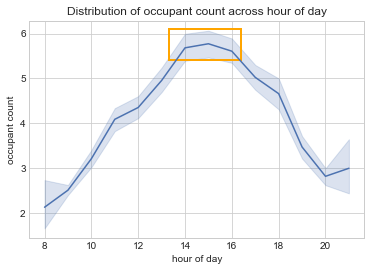

In [272]:
mpl.style.use('seaborn-whitegrid')
sns.lineplot(x=hours, y=df['occupant_count [number]'])
plt.title('Distribution of occupant count across hour of day')
ax = plt.gca()
ax.add_patch(patches.Rectangle((13.3, 5.4), 3.1, 0.7, edgecolor='orange', \
    facecolor='none', linewidth=2))
plt.ylabel('occupant count')
plt.xlabel('hour of day')
plt.show();

[[1.        0.4428711]
 [0.4428711 1.       ]]


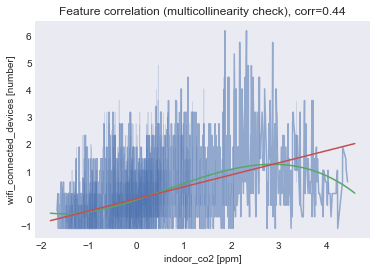

In [273]:
# sanity check

arr1 = (df['indoor_co2 [ppm]']-indoorCO2Mean)/indoorCO2Std
arr2 = (df['wifi_connected_devices [number]']-wifiDevicesMean)/wifiDevicesStd

print(np.corrcoef(arr1, arr2))
line = np.linspace(-1.8, 4.6, 100)
mdl = np.poly1d(np.polyfit(arr1, arr2, 1))
mdl3 = np.poly1d(np.polyfit(arr1, arr2, 3))

# mpl.style.use('seaborn-dark-palette')
# mpl.style.use('seaborn-darkgrid')
# mpl.style.use('seaborn-deep')
mpl.style.use('seaborn-dark')

sns.lineplot(x=arr1, y=arr2, alpha=0.55)
plt.plot(line, mdl3(line))
plt.plot(line, mdl(line))

plt.title(f'Feature correlation (multicollinearity check), corr={np.round(mdl.coef[0], 2)}');

In [274]:
lrPerformance[('lin-reg', 'one-hot')] = lrRMSE

In [295]:
# Repeat for sin/cos and RBF hour transformations (Linear regression)

# Record prediction values for each model examine their distribution
model = []
predVal = []

for trans in ['one-hot', 'sin/cos', 'rbf']:
    X = []
    y = []
    df.apply(feat, hourEncoding=trans, axis=1)

    threshold = int(len(X)*0.75)
    XTrain = X[:threshold]
    XTest = X[threshold:]
    yTrain = y[:threshold]
    yTest = y[threshold:]
    featSample = X[0]

    # Model initiation and fit
    mdl = linear_model.LinearRegression(fit_intercept=False)
    mdl.fit(XTrain, yTrain)

    # Make predictions and get RMSE
    trainPreds = mdl.predict(XTrain)
    trainRMSE = RMSE(yTrain, trainPreds)
    testPreds = mdl.predict(XTest)
    testRMSE = RMSE(yTest, testPreds)

    lrPerformance[('lin-reg', trans)] = testRMSE
    lrTrainPerformance[('lin-reg', trans)] = trainRMSE
    model += [f'lin-reg, {trans}']*len(testPreds)
    predVal += list(preds)

    # Examine model
    print(f'Model - lin-reg, {trans}')
    print(f'Learning feature sample: {featSample}')
    # print(f'{featSample}')
    print(f'coefficients: {mdl.coef_}')
    # print(f'{mdl.coef_}')
    print('')


Model - lin-reg, one-hot
Learning feature sample: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.288331218068863, 0.20005668386070682]
coefficients: [2.51017815 0.14027575 0.45693332 1.37661187 1.87173858 1.86087422
 2.44248679 3.27343789 3.4271599  3.40350706 2.29825606 1.79139328
 1.14432045 0.63069239 0.62363237 0.99554744]

Model - lin-reg, sin/cos
Learning feature sample: [1, 0.8660254037844387, -0.4999999999999998, 0.288331218068863, 0.20005668386070682]
coefficients: [ 2.59559811 -1.90356412 -2.35367418  0.56816412  1.01537706]

Model - lin-reg, rbf
Learning feature sample: [1, 0.2271734201167346, 0.95384034078631, 0.5420069956565414, 0.041681672223569, 0.288331218068863, 0.20005668386070682]
coefficients: [-124.02729455   68.55032542   70.57850723   73.96893252   74.02193929
    0.6221681     0.9940373 ]



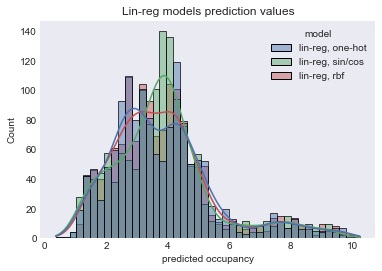

In [293]:
# Plot distribution of prediction values

predVariety = pd.DataFrame(data={'model': model, 'predVal': predVal})
sns.histplot(data=predVariety, x='predVal', hue='model', kde=True, alpha=0.46);
plt.title('Lin-reg models prediction values')
plt.xlabel('predicted occupancy');

In [296]:
lrPerformance

defaultdict(float,
            {('lin-reg', 'one-hot'): 2.2334939506347933,
             ('lin-reg', 'sin/cos'): 2.243164827500044,
             ('lin-reg', 'rbf'): 2.2266253252047497})

In [297]:
lrTrainPerformance

defaultdict(float,
            {('lin-reg', 'one-hot'): 2.3504687786936733,
             ('lin-reg', 'sin/cos'): 2.3696494143564286,
             ('lin-reg', 'rbf'): 2.3559523957528716})